# Monte-Carlo-Simulation

To ensure reproducibility, a fixed random seed was set at the beginning of the Monte Carlo simulation. This means that all results are exactly reproducible with identical parameters.

In [3]:
import numpy as np
SEED = 42
np.random.seed(SEED)

we will import all the necessary functions from the source module 

In [4]:
from src.sampling import sample_salpeter, sample_metallicity
from src.stellar_physics import ms_lifetime_years, stellar_endpoint
from src.supernovae import is_type_ia, core_collapse_SN_type

## simulation a star population

### 1. sampling a star population of N=100000 
mass and metallicity are given **in relation to the sun**

In [5]:
N = 100000

masses = sample_salpeter(N)
masses = np.atleast_1d(masses)

metallicities = sample_metallicity(N)
metallicities = np.atleast_1d(metallicities)

print("Sampled masses:", masses)
print("Sampled metallicities:", metallicities)

Sampled masses: [0.14156184 0.92854363 0.26516627 ... 0.22959789 0.16695565 0.14419439]
Sampled metallicities: [0.01746529 0.01585645 0.010596   ... 0.00584689 0.01962717 0.00014665]


### 2. using stellar physics to determine lifetimes and endstates

In [6]:
lifetimes = np.array([
    ms_lifetime_years(masses, metallicities)
    for masses, metallicities in zip(masses, metallicities)
])
print("Computed lifetimes:", lifetimes)

endstates = np.array([
    stellar_endpoint(m) 
    for m in np.array(masses)
    ])
print("Determined stellar endpoints:", endstates)

Computed lifetimes: [1.38625805e+12 1.23398480e+10 2.61220412e+11 ... 3.32460176e+11
 9.39383911e+11 5.08929697e+11]
Determined stellar endpoints: ['WD' 'WD' 'WD' ... 'WD' 'WD' 'WD']


### 3. determining supernovae (and their types)

In [7]:
cc_sn_types = np.array([
    core_collapse_SN_type(m)
    for m in masses
    ])  
print("Determined core-collapse SN types:", cc_sn_types)

ia_flags = np.array([
    is_type_ia(m)
    for m in masses
    ])  
print("Determined Type Ia flags:", ia_flags)

sn_types = np.where(ia_flags, "Type Ia", cc_sn_types)
print("Determined supernova types:", sn_types)

Determined core-collapse SN types: [None None None ... None None None]
Determined Type Ia flags: [False False False ... False False False]
Determined supernova types: [None None None ... None None None]


### 4. summary

![hm](figures.StarEvalution.webp)

In [8]:
total_cc = np.sum(cc_sn_types != None)
total_Ia = np.sum(ia_flags)
total_SN = total_cc + total_Ia

print("===== SUMMARY =====")
print(f"Total stars: {N}")
print(f"Core-collapse SN:  {total_cc} ({total_cc/N*100:.3f} %)")
print(f"Type Ia SN:        {total_Ia} ({total_Ia/N*100:.3f} %)")
print(f"All supernovae:   {total_SN} ({total_SN/N*100:.3f} %)")

unique, counts = np.unique(sn_types[sn_types != None], return_counts=True)
print("\nSupernovae types:")
for u, c in zip(unique, counts):
    print(f"{u}: {c}")


===== SUMMARY =====
Total stars: 100000
Core-collapse SN:  251 (0.251 %)
Type Ia SN:        980 (0.980 %)
All supernovae:   1231 (1.231 %)

Supernovae types:
Type II: 181
Type Ia: 980
Type Ib: 48
Type Ic: 22


### 5. plots

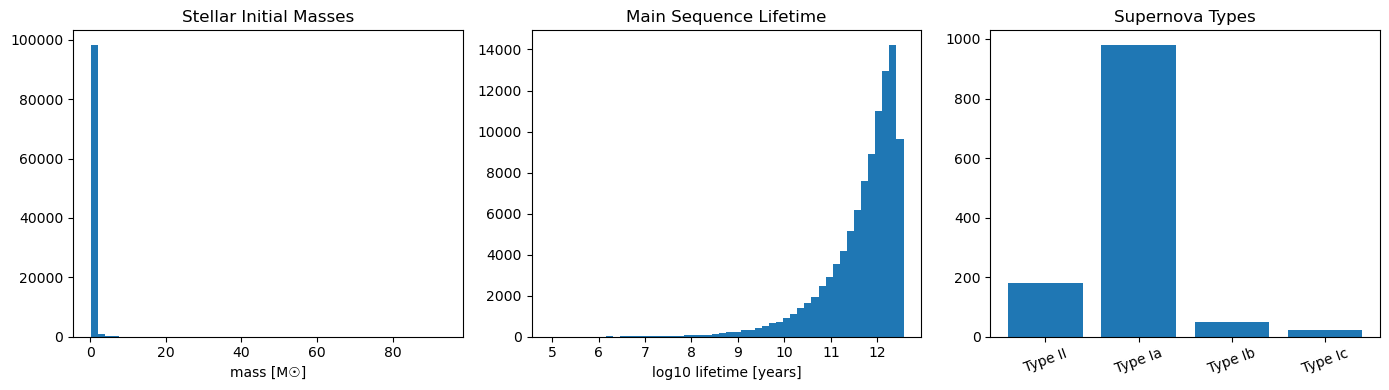

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,4))

plt.subplot(1,3,1)
plt.hist(masses, bins=50)
plt.xlabel("mass [M☉]")
plt.title("Stellar Initial Masses")

plt.subplot(1,3,2)
plt.hist(np.log10(lifetimes), bins=50)
plt.xlabel("log10 lifetime [years]")
plt.title("Main Sequence Lifetime")

plt.subplot(1,3,3)
plt.bar(unique, counts)
plt.title("Supernova Types")
plt.xticks(rotation=20)

plt.tight_layout()
plt.show()

## How do the supernova rate and type distribution change depending on the initial conditions of a star population?

we will now look at how changing comparitive parameters can change our output
we will vary: maximum mass when sampling masses
we will see: rare core-collapse sn will happen more often?

(other interesting parameters we did not choose: varying binary fraction, IMF-function, distribution of metallicity, ia-efficiancy)

one single mc-realisation:

In [10]:
from src.mc_functions import run_single_mc, mc_statistics


In [11]:
### THIS STEP TAKES ABOUT 3-4 MINUTES TO RUN ###

N = 100000
n_realizations = 100

m_max_values = [30, 50, 80, 120, 150, 200]

comparison_results = {}

for m_max in m_max_values:
    stats = mc_statistics(N=N, m_max=m_max, n_realizations=n_realizations)
    comparison_results[m_max] = stats


In [12]:
for m_max, stats in comparison_results.items():
    print(f"\nm_max = {m_max} m_sun")
    for sn_type, values in stats.items():
        print(
            f"  {sn_type:15s} "
            f"mean={values['mean']:.1f}, "
            f"std={values['std']:.1f}, "
            f"CI68={values['ci_68']}, "
            f"CI95={values['ci_95']}"
        )



m_max = 30 m_sun
  core_collapse   mean=226.3, std=16.0, CI68=(np.float64(210.84), np.float64(242.16)), CI95=(np.float64(196.475), np.float64(259.19999999999993))
  type_ia         mean=0.0, std=0.0, CI68=(np.float64(0.0), np.float64(0.0)), CI95=(np.float64(0.0), np.float64(0.0))
  total           mean=226.3, std=16.0, CI68=(np.float64(210.84), np.float64(242.16)), CI95=(np.float64(196.475), np.float64(259.19999999999993))

m_max = 50 m_sun
  core_collapse   mean=246.1, std=16.6, CI68=(np.float64(231.0), np.float64(260.32)), CI95=(np.float64(211.0), np.float64(277.0))
  type_ia         mean=0.0, std=0.0, CI68=(np.float64(0.0), np.float64(0.0)), CI95=(np.float64(0.0), np.float64(0.0))
  total           mean=246.1, std=16.6, CI68=(np.float64(231.0), np.float64(260.32)), CI95=(np.float64(211.0), np.float64(277.0))

m_max = 80 m_sun
  core_collapse   mean=259.8, std=15.7, CI68=(np.float64(245.68), np.float64(274.15999999999997)), CI95=(np.float64(231.475), np.float64(289.0))
  type_ia    

In [13]:
import pandas as pd

rows = []

for m_max, stats in comparison_results.items():
    cc = stats["core_collapse"]
    
    rows.append({
        "M_max": m_max,
        "CCSN_mean": cc["mean"],
        "CCSN_std": cc["std"],
        "CCSN_CI95_low": cc["ci_95"][0],
        "CCSN_CI95_high": cc["ci_95"][1]
    })

df_results = pd.DataFrame(rows)
df_results = df_results.sort_values("M_max").reset_index(drop=True)

df_results


,M_max,CCSN_mean,CCSN_std,CCSN_CI95_low,CCSN_CI95_high
0,30,226.27,15.983486,196.475,259.200
1,50,246.07,16.641954,211.000,277.000
2,80,259.83,15.714019,231.475,289.000
3,120,261.58,14.183630,235.475,286.575
4,150,264.27,17.895801,227.475,296.525
5,200,267.43,16.270600,236.000,296.525


visualisation Wie beeinflusst die maximale Sternmasse die core-collapse-Supernova-Raten?

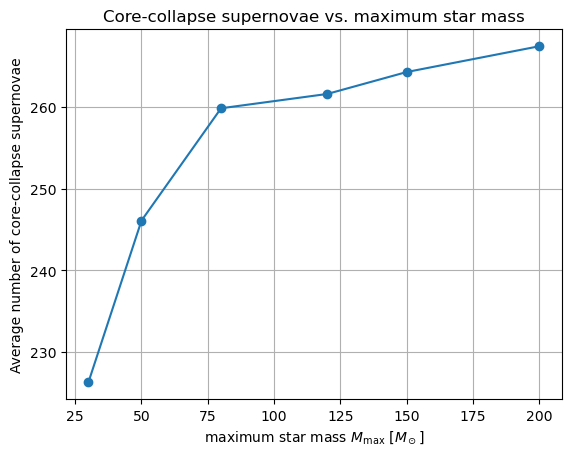

In [14]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(
    df_results["M_max"],
    df_results["CCSN_mean"],
    marker="o"
)

plt.xlabel(r"maximum star mass $M_{\mathrm{max}}$ [$M_\odot$]")
plt.ylabel("Average number of core-collapse supernovae")
plt.title("Core-collapse supernovae vs. maximum star mass")
plt.grid(True)
plt.show()


In [15]:
md_table = df_results.to_markdown(
    index=False,
    floatfmt=".2f"
)

print(md_table)


|   M_max |   CCSN_mean |   CCSN_std |   CCSN_CI95_low |   CCSN_CI95_high |
|--------:|------------:|-----------:|----------------:|-----------------:|
|   30.00 |      226.27 |      15.98 |          196.47 |           259.20 |
|   50.00 |      246.07 |      16.64 |          211.00 |           277.00 |
|   80.00 |      259.83 |      15.71 |          231.47 |           289.00 |
|  120.00 |      261.58 |      14.18 |          235.47 |           286.57 |
|  150.00 |      264.27 |      17.90 |          227.47 |           296.52 |
|  200.00 |      267.43 |      16.27 |          236.00 |           296.52 |
